In [1]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import scipy.io

import os, re

import claude.utils as cu
import claude.claudeflow.autoencoder as ae
import claude.claudeflow.helper as cfh

In [2]:
seed = 42
tf.set_random_seed(seed)
np.random.seed(seed)

# Parameters
# Channel Parameters
chParam = cu.AttrDict()
chParam.M = 16

# Auto-Encoder Parameters
aeParam = cu.AttrDict()
aeParam.dimension	= 2
aeParam.nLayers		= 2
aeParam.hiddenUnits	= 32
aeParam.activation  = tf.nn.selu
aeParam.dropout		= False
aeParam.dtype       = tf.float32

# Training Parameters
trainingParam = cu.AttrDict()
trainingParam.sampleSize	= 512*chParam.M # Increase for better results (especially if M>16)
trainingParam.batchSize 	= 32*chParam.M  # Increase for better results (especially if M>16)
trainingParam.learningRate	= 0.001
trainingParam.displayStep	= 20
trainingParam.path			= 'results_AWGN_end2end'
trainingParam.filename		= 'M{}'.format(chParam.M)
trainingParam.earlyStopping = 250
trainingParam.iterations = 250

# TF constants
two = tf.constant(2,aeParam.dtype)
DIM = tf.constant(aeParam.dimension,aeParam.dtype)
PI = tf.constant(np.pi,aeParam.dtype)

In [3]:
# Tx Graph     
X = tf.placeholder( aeParam.dtype, shape=(None, chParam.M) )
enc = ae.encoder(X,aeParam.hiddenUnits,aeParam.nLayers,aeParam.activation,nOutput=aeParam.dimension)
enc_norm = cfh.IQ_norm( enc )

# Channel Graph
sigma2_noise = tf.constant(0.1,aeParam.dtype)
noise = tf.sqrt( sigma2_noise )\
            *tf.rsqrt(two)\
            *tf.random_normal(shape=tf.shape(enc_norm),dtype=aeParam.dtype)
channel_out = enc_norm + noise

# Rx Graph
dec = ae.decoder(channel_out,aeParam.hiddenUnits,aeParam.nLayers,aeParam.activation,chParam.M)
per_ex_loss = tf.nn.softmax_cross_entropy_with_logits_v2(labels=X,logits=dec)

In [4]:
# Loss
correct_prediction = tf.equal(tf.argmax(X,1), tf.argmax(dec,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, aeParam.dtype))
loss = tf.reduce_mean(per_ex_loss)

optimizer = tf.train.AdamOptimizer(learning_rate=trainingParam.learningRate).minimize(loss)

avg_loss, avg_loss_update, avg_loss_reset = cfh.create_reset_metric(tf.metrics.mean, 'loss_metric', loss)
avg_accuracy, avg_accuracy_update, avg_accuracy_reset = cfh.create_reset_metric(tf.metrics.mean, 'accuracy_metric', accuracy)
reset_ops = [avg_loss_reset,avg_accuracy_reset]
update_ops = [avg_loss_update,avg_accuracy_update]

In [5]:
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

saver = tf.train.Saver()
checkpoint_path = os.path.join(trainingParam.path,'checkpoint',trainingParam.filename,'best')
if not os.path.exists(checkpoint_path):
    os.makedirs(checkpoint_path)
else:
    pass
#     print("Restoring checkpoint...", flush=True)
#     saver.restore(sess=sess,save_path=checkpoint_path)

In [6]:
nBatches = int(trainingParam.sampleSize/trainingParam.batchSize)
bestLoss = 10000

for epoche in range(1, trainingParam.iterations+1):
    sess.run(reset_ops)
    for batch in range(0,nBatches):
        data, _, _ = cu.hotOnes(trainingParam.batchSize,(1,0),chParam.M)
        feedDict = {X: data}
        sess.run([optimizer, update_ops], feed_dict=feedDict)

    [outAvgLoss, outAvgAccuracy] = sess.run([avg_loss, avg_accuracy], feed_dict=feedDict)

    if outAvgLoss < bestLoss:
        bestLoss = outAvgLoss
        lastImprovement = epoche
        saver.save(sess=sess,save_path=checkpoint_path)

    if epoche - lastImprovement > trainingParam.earlyStopping:
        print("Breaking due to no improvement")
        break;

    if epoche%trainingParam.displayStep == 0:
        print('epoche: {} - avgLoss: {} - avgAcc: {}'.format(epoche,outAvgLoss,outAvgAccuracy))

epoche: 20 - avgLoss: 0.7039861083030701 - avgAcc: 0.7791748046875
epoche: 40 - avgLoss: 0.5788153409957886 - avgAcc: 0.77587890625
epoche: 60 - avgLoss: 0.5455521941184998 - avgAcc: 0.789794921875
epoche: 80 - avgLoss: 0.5596516132354736 - avgAcc: 0.789306640625
epoche: 100 - avgLoss: 0.5454341769218445 - avgAcc: 0.7938232421875
epoche: 120 - avgLoss: 0.5539963841438293 - avgAcc: 0.79248046875
epoche: 140 - avgLoss: 0.5641120672225952 - avgAcc: 0.7891845703125
epoche: 160 - avgLoss: 0.5461405515670776 - avgAcc: 0.79150390625
epoche: 180 - avgLoss: 0.5454663634300232 - avgAcc: 0.796142578125
epoche: 200 - avgLoss: 0.5554857850074768 - avgAcc: 0.7872314453125
epoche: 220 - avgLoss: 0.5496293902397156 - avgAcc: 0.788818359375
epoche: 240 - avgLoss: 0.5394671559333801 - avgAcc: 0.7943115234375


INFO:tensorflow:Restoring parameters from results_AWGN_end2end/checkpoint/M16/best


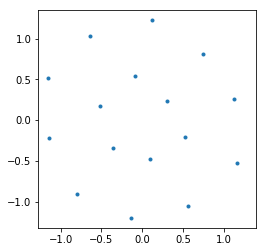

In [7]:
saver.restore(sess=sess,save_path=checkpoint_path)
data, idx, xseed = cu.hotOnes(trainingParam.batchSize,(1,0),chParam.M)
feedDict = {X: xseed}
pred_const = sess.run(enc_norm, feed_dict=feedDict)
plt.plot(pred_const[:,0],pred_const[:,1],'.')
plt.axis('square');